# Forward selection using Logistic regression

## Representation

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
class LogisticRegression:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y, single_feature= False):
        n_samples, n_features = X.shape 

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            # approximate y with linear combination of weights and x, plus bias
            linear_model = np.dot(X, self.weights) + self.bias
            # apply sigmoid function
            y_predicted = self._sigmoid(linear_model)

            # compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            # update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))



In [3]:
def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

In [4]:
# Load csv file 
df = pd.read_csv('../datasets/mushrooms.csv', index_col=False)
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [5]:
df.shape

(8124, 23)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [7]:
from sklearn.preprocessing import LabelEncoder
def label_encoded(feat):
    le = LabelEncoder()
    le.fit(feat)
    print(feat.name,le.classes_)
#     print(le.classes_)
    return le.transform(feat)

In [8]:
for col in df.columns:
    df[str(col)] = label_encoded(df[str(col)])

class ['e' 'p']
cap-shape ['b' 'c' 'f' 'k' 's' 'x']
cap-surface ['f' 'g' 's' 'y']
cap-color ['b' 'c' 'e' 'g' 'n' 'p' 'r' 'u' 'w' 'y']
bruises ['f' 't']
odor ['a' 'c' 'f' 'l' 'm' 'n' 'p' 's' 'y']
gill-attachment ['a' 'f']
gill-spacing ['c' 'w']
gill-size ['b' 'n']
gill-color ['b' 'e' 'g' 'h' 'k' 'n' 'o' 'p' 'r' 'u' 'w' 'y']
stalk-shape ['e' 't']
stalk-root ['?' 'b' 'c' 'e' 'r']
stalk-surface-above-ring ['f' 'k' 's' 'y']
stalk-surface-below-ring ['f' 'k' 's' 'y']
stalk-color-above-ring ['b' 'c' 'e' 'g' 'n' 'o' 'p' 'w' 'y']
stalk-color-below-ring ['b' 'c' 'e' 'g' 'n' 'o' 'p' 'w' 'y']
veil-type ['p']
veil-color ['n' 'o' 'w' 'y']
ring-number ['n' 'o' 't']
ring-type ['e' 'f' 'l' 'n' 'p']
spore-print-color ['b' 'h' 'k' 'n' 'o' 'r' 'u' 'w' 'y']
population ['a' 'c' 'n' 's' 'v' 'y']
habitat ['d' 'g' 'l' 'm' 'p' 'u' 'w']


In [9]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [10]:
X = df.drop(['class'],axis=1)
y = df['class']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=3, stratify=y_train)

# Optimisation

## Hyperparameter tuning

In [12]:
learning_rates=[0.1,0.01,0.001,0.0001]

In [13]:
def hypTune(X_train, y_train, X_val, y_val):
    scores = []
    for lr in learning_rates:
        logReg = LogisticRegression(lr)
        logReg.fit(X_train, y_train)
        predict = logReg.predict(X_val)
        acc = accuracy(y_val, predict)
        scores.append(acc)
    return scores

In [14]:
scores = hypTune(X_train, y_train, X_val, y_val)
scores

[0.9261862917398945,
 0.8708260105448155,
 0.8005272407732865,
 0.7513181019332161]

## Forward selection

### Psuedocode

1. Start with empty SF set $A = \emptyset$
2. Initialise candidate set to be all original attributes $A_c = A$
3. Find attribute $a_i$ with highest filter score
4. Remove feature $a_i$ from candidate set: $A_c \gets A \cap a_i$
5. Add feature $a_i$ to SF set:$A_s \gets A_s \cup a_i$
6. Repeat steps 3-5 until convergence

Filter types:
- Correlation
- Mutual information
- Entropy
- Classification rate
- Regression score

In [15]:
col_names = X_train.columns
col_names

Index(['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [140]:
features_toTest = []
features_toTest.append(col_names[0])
features_toTest.append(col_names[1])
test = X[[col_names[0]]]
lg = LogisticRegression(0.1)

# split data
X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.3, random_state=1, stratify=y)

lg.fit(X_train, y_train)
predict = lg.predict(X_test)
# Calculate accuracy
acc = accuracy(y_test, predict)

In [142]:
features_toTest.dtype

AttributeError: 'list' object has no attribute 'dtype'

In [133]:
features_toTest.remove(col_names[0])

In [134]:
features_toTest

[]

In [105]:
test

,cap-shape
0,5
1,5
2,0
3,5
4,5
...,...
8119,3
8120,5
8121,2
8122,3


In [53]:
features_toTest

['cap-shape']

In [84]:
print(test.columns[0])


cap-shape


In [44]:
ttest = X[col_names[0]]
ttest

0       5
1       5
2       0
3       5
4       5
       ..
8119    3
8120    5
8121    2
8122    3
8123    5
Name: cap-shape, Length: 8124, dtype: int64

In [47]:
def forwardSelection(X, y, learning_rate):
    # initilise arrays
    col_names= X.columns
    selected_features=[]
    
    # initialise high score and logistic regression model
    high_score=[[], 0]   
    log_reg = LogisticRegression(learning_rate)
    
    # start first loop
    for i in range(0,len(col_names)-1):
        candidate_features=selected_features
        # select first feature
        candidate_features.append(col_names[i])
        for j in range(1,len(col_names)):
            candidate_features.append(col_names[j])
            test_features = X[candidate_features]
            # split data
            X_train, X_val, y_train, y_val = train_test_split(test, y, 
                                                                test_size=0.3, random_state=1, stratify=y)
            # train model
            log_reg.fit(X_train, y_train)
            # Predict
            predict = log_reg.predict(X_val)
            # Calculate accuracy
            acc = accuracy(y_val, predict)
            print(f"comparing col{i} : {j}")

            # high score
            if acc > high_score[1]:
                high_score = [test_features, acc]
                print(acc)
            
    selected_features.append(high_score[0])
    print(selected_features)
            

In [48]:
forwardSelection(X, y, 0.1)

comparing col0 : 1
0.4807219031993437
comparing col0 : 2
comparing col0 : 3
comparing col0 : 4
comparing col0 : 5
comparing col0 : 6
comparing col0 : 7
comparing col0 : 8
comparing col0 : 9
comparing col0 : 10
comparing col0 : 11
comparing col0 : 12
comparing col0 : 13
comparing col0 : 14
comparing col0 : 15
comparing col0 : 16
comparing col0 : 17
comparing col0 : 18
comparing col0 : 19
comparing col0 : 20
comparing col0 : 21
comparing col1 : 1
comparing col1 : 2
comparing col1 : 3
comparing col1 : 4
comparing col1 : 5
comparing col1 : 6
comparing col1 : 7
comparing col1 : 8
comparing col1 : 9
comparing col1 : 10
comparing col1 : 11
comparing col1 : 12
comparing col1 : 13
comparing col1 : 14
comparing col1 : 15
comparing col1 : 16
comparing col1 : 17
comparing col1 : 18
comparing col1 : 19
comparing col1 : 20
comparing col1 : 21
comparing col2 : 1
comparing col2 : 2
comparing col2 : 3
comparing col2 : 4
comparing col2 : 5
comparing col2 : 6
comparing col2 : 7
comparing col2 : 8
compari

KeyboardInterrupt: 

In [158]:
col_names= list(X.columns)
del col_names[0]

In [161]:
def forwardSelection2(X, y, learning_rate):
    # initilise arrays
    col_names= list(X.columns)
    selected_features=[]
    
    # initialise high score and logistic regression model
    high_score=0
    best_feature=" "
    model_improvement = True
    log_reg = LogisticRegression(learning_rate)
    # Outer loop
    loopNum = 0
    while model_improvement==True:
        # inner loop
        print(f"Loop number:{loopNum}")
        loopNum+=1
        for i in range(0,len(col_names)-1):
            model_improvement == False
            candidate_features=selected_features
            candidate_features.append(col_names[i])
            features_to_train = X[candidate_features]

            # split data
            X_train, X_val, y_train, y_val = train_test_split(features_to_train, y, 
                                                                test_size=0.3, random_state=1, stratify=y)
            # train model
            log_reg.fit(X_train, y_train)
            # Predict
            predict = log_reg.predict(X_val)
            # Calculate accuracy
            acc = accuracy(y_val, predict)
            #print(f"comparing col{i}")

            # high score
            if acc > high_score:
                model_improvement == True
                high_score = acc
                best_feature = candidate_features[i]
                print(acc)

        print(high_score)        
        selected_features.append(best_feature)
        del col_names[i]
        print(best_feature)
    return selected_features
    

In [162]:
selectFeatures = forwardSelection2(X, y, 0.1)

Loop number:0
0.4807219031993437
0.5586546349466776
0.5898277276456112
0.712059064807219
0.7744052502050861
0.8096800656275636
0.8511074651353568
0.9097621000820345
0.9216570959803118
0.9232977850697293
0.9249384741591469
0.9249384741591469
ring-type
Loop number:1
0.9269893355209188
0.9310910582444627
0.9319114027891715
0.933552091878589
0.933552091878589
ring-type
Loop number:2
0.933552091878589
ring-type
Loop number:3
0.9339622641509434
0.9339622641509434
stalk-surface-below-ring
Loop number:4
0.9339622641509434
stalk-surface-below-ring
Loop number:5
0.9339622641509434
stalk-surface-below-ring
Loop number:6
0.9343724364232978
0.9343724364232978
gill-spacing
Loop number:7
0.9343724364232978
gill-spacing
Loop number:8
0.9343724364232978
gill-spacing
Loop number:9
0.9343724364232978
gill-spacing
Loop number:10
0.9343724364232978
gill-spacing
Loop number:11
0.9351927809680065
0.9351927809680065
cap-surface
Loop number:12
0.9351927809680065
cap-surface
Loop number:13
0.9351927809680065
ca

KeyboardInterrupt: 

# Evaluation

In [22]:
accuracy(y_test, predicted)

0.8092698933552092

In [19]:
# We use confusion matrix (TP, TN, FP, FN) to visualise the performance

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, predicted)

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1236
           1       0.89      0.74      0.81      1202

    accuracy                           0.83      2438
   macro avg       0.84      0.83      0.83      2438
weighted avg       0.84      0.83      0.83      2438



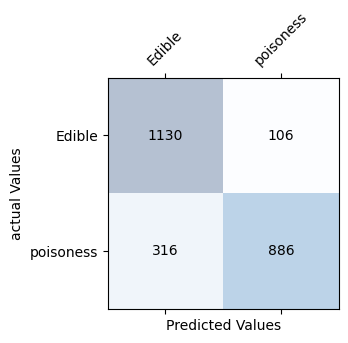

In [21]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
classes=["Edible", "poisoness"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values',)
plt.ylabel('actual Values',);
print(classification_report(y_test, predicted))